Upi transaction fraud detection

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


In [7]:
df = pd.read_csv("/content/upi_generated_5000_10pct-1.csv") # Make sure this file exists in your Colab environment or update the path to the correct location. You can upload the file using the folder icon on the left panel, and then copy its path.

print("Shape:", df.shape)
print("\nFraud distribution BEFORE balancing:")
print(df["fraud_flag"].value_counts())
df.head()

Shape: (5000, 6)

Fraud distribution BEFORE balancing:
fraud_flag
0    2608
1    2392
Name: count, dtype: int64


,transaction_type,merchant_category,hour_of_day,is_weekend,amount_inr,fraud_flag
0,BankTransfer,Shopping,18,1,82,0
1,P2M,Food,21,0,878,0
2,P2P,Shopping,22,0,199,0
3,P2P,Travel,5,0,140,1
4,P2M,Travel,17,0,65,1


In [8]:
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

df["hour_of_day"] = df["hour_of_day"].astype(int)
df["is_weekend"] = df["is_weekend"].astype(int)
df["fraud_flag"] = df["fraud_flag"].astype(int)
print("\nMissing values per column:")
print(df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())

print("\nData Types:")
print(df.dtypes)


Missing values per column:
transaction_type     0
merchant_category    0
hour_of_day          0
is_weekend           0
amount_inr           0
fraud_flag           0
dtype: int64

Duplicate rows: 75

Data Types:
transaction_type     object
merchant_category    object
hour_of_day           int64
is_weekend            int64
amount_inr            int64
fraud_flag            int64
dtype: object


/tmp/ipython-input-679680908.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="fraud_flag", data=df, palette="viridis")


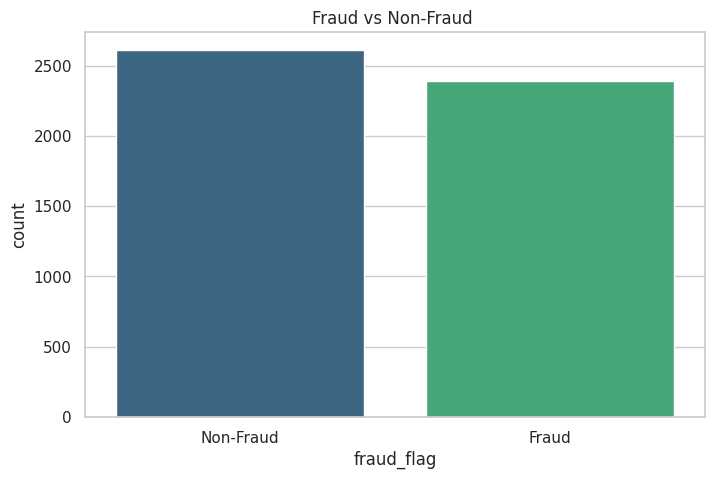

In [9]:
plt.figure()
sns.countplot(x="fraud_flag", data=df, palette="viridis")
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.title("Fraud vs Non-Fraud ")
plt.show()

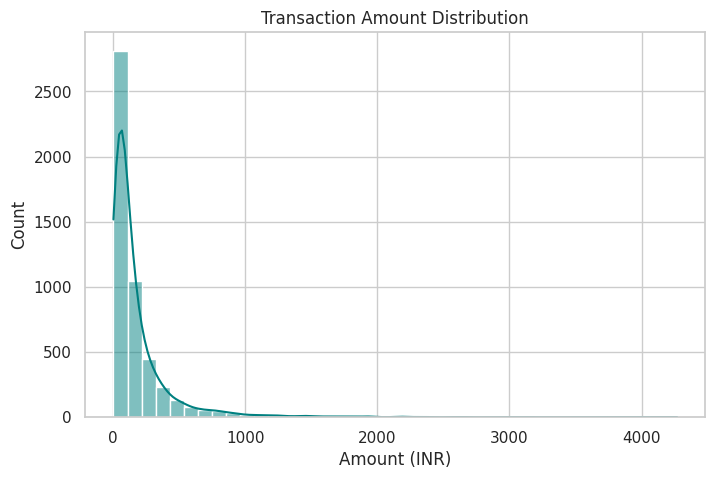

In [10]:
plt.figure()
sns.histplot(df["amount_inr"], bins=40, kde=True, color="teal")
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount (INR)")
plt.show()

/tmp/ipython-input-62077310.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fraud_flag", y="amount_inr", data=df, palette="magma")


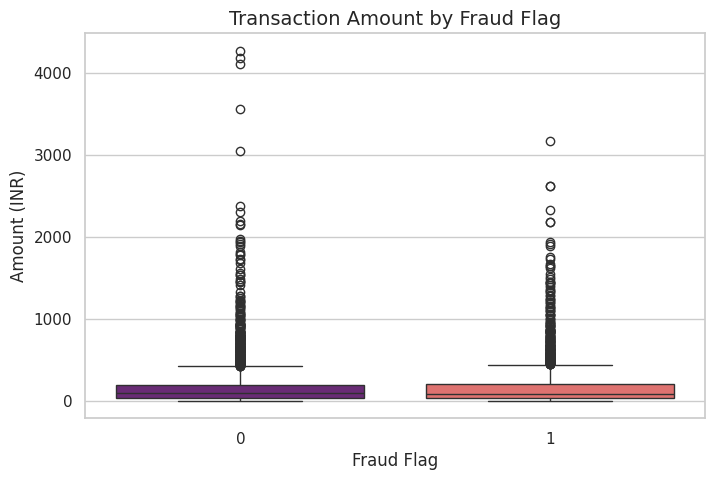

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(x="fraud_flag", y="amount_inr", data=df, palette="magma")
plt.title("Transaction Amount by Fraud Flag", fontsize=14)
plt.xlabel("Fraud Flag", fontsize=12)
plt.ylabel("Amount (INR)", fontsize=12)
plt.show()

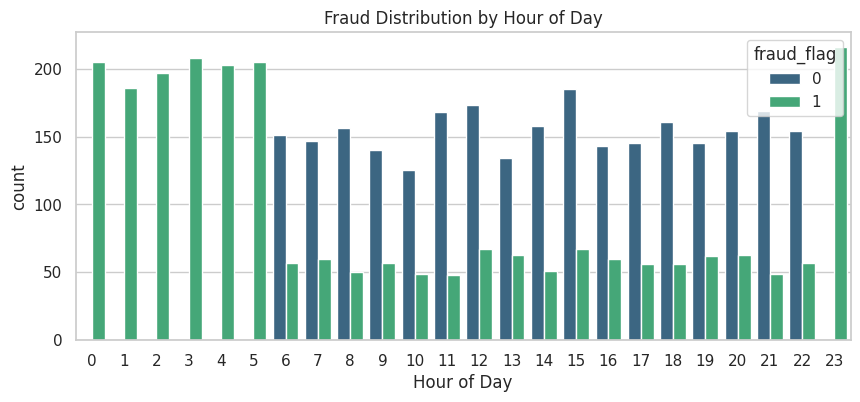

In [12]:
plt.figure(figsize=(10,4))
sns.countplot(x="hour_of_day", hue="fraud_flag", data=df, palette="viridis")
plt.title("Fraud Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.show()

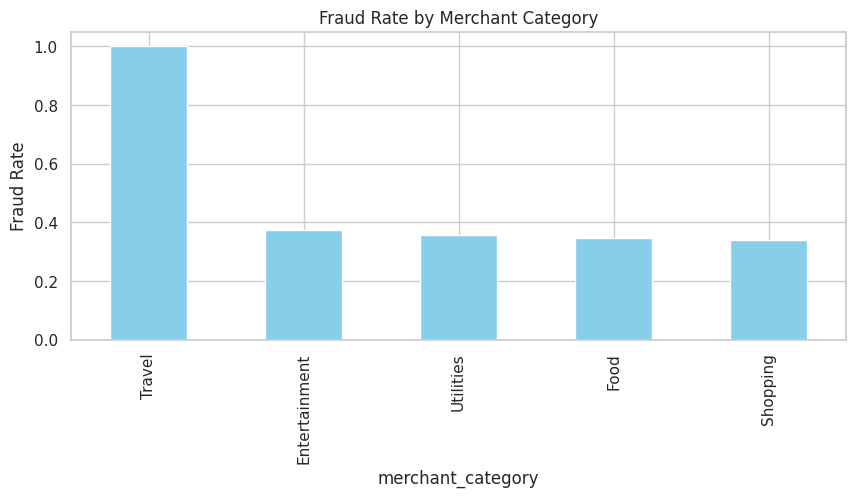

In [13]:
cat_tab = pd.crosstab(df["merchant_category"], df["fraud_flag"])
fraud_rate = (cat_tab[1] / cat_tab.sum(axis=1)).sort_values(ascending=False)

plt.figure(figsize=(10,4))
fraud_rate.plot(kind="bar", color="skyblue")
plt.title("Fraud Rate by Merchant Category")
plt.ylabel("Fraud Rate")
plt.show()

Shape AFTER balancing: (3608, 6)

Fraud distribution AFTER balancing:
fraud_flag
0    2608
1    1000
Name: count, dtype: int64


/tmp/ipython-input-1363224551.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="fraud_flag", data=df_bal, palette="viridis")


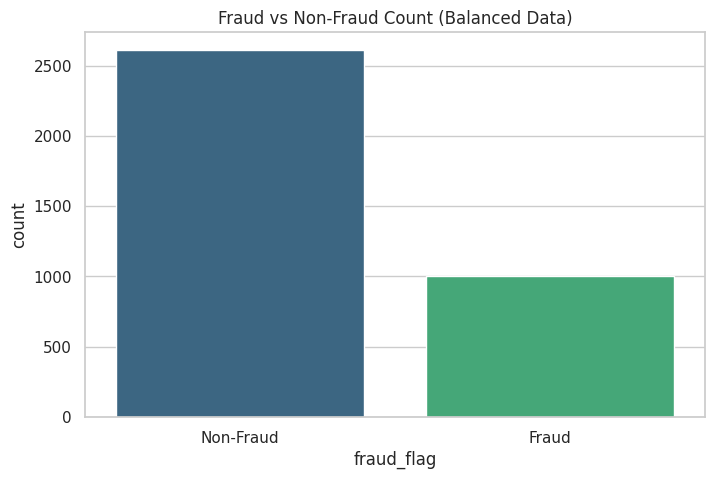

In [14]:
# CELL 5 : BALANCING
fraud = df[df["fraud_flag"] == 1]
nonfraud = df[df["fraud_flag"] == 0]

# Upsample fraud cases
fraud_bal = fraud.sample(n=1000, replace=True, random_state=42)

# Downsample non-fraud cases, ensuring not to sample more than available
# The target is 4000, but if nonfraud has fewer than 4000, sample all of them.
n_nonfraud_sample = min(len(nonfraud), 4000)
nonfraud_bal = nonfraud.sample(n=n_nonfraud_sample, replace=False, random_state=42)

df_bal = pd.concat([fraud_bal, nonfraud_bal]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Shape AFTER balancing:", df_bal.shape)
print("\nFraud distribution AFTER balancing:")
print(df_bal["fraud_flag"].value_counts())

plt.figure()
sns.countplot(x="fraud_flag", data=df_bal, palette="viridis")
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.title("Fraud vs Non-Fraud Count (Balanced Data)")
plt.show()

In [15]:
# CELL 6 Feature engineering
df_bal["amount_log"] = np.log1p(df_bal["amount_inr"])
df_bal["is_night"] = df_bal["hour_of_day"].apply(lambda x: 1 if (x <= 5 or x >= 23) else 0)

# Selected features
features = [
    "transaction_type",
    "merchant_category",
    "hour_of_day",
    "is_weekend",
    "is_night",
    "amount_log"
]

print("Selected Features:", features)

X = df_bal[features]
y = df_bal["fraud_flag"]
df.head()

categorical_cols = ["transaction_type", "merchant_category"]
numeric_cols = ["hour_of_day", "is_weekend", "is_night", "amount_log"]

Selected Features: ['transaction_type', 'merchant_category', 'hour_of_day', 'is_weekend', 'is_night', 'amount_log']


In [16]:
# CELL 7: TRAIN / TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (2886, 6)
Test shape: (722, 6)


In [17]:
# CELL 8: PREPROCESSOR (OHE + STANDARDIZE)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ]
)

=============== XGBOOST RESULTS ==============
Accuracy: 0.9626038781163435

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       522
           1       0.99      0.87      0.93       200

    accuracy                           0.96       722
   macro avg       0.97      0.93      0.95       722
weighted avg       0.96      0.96      0.96       722



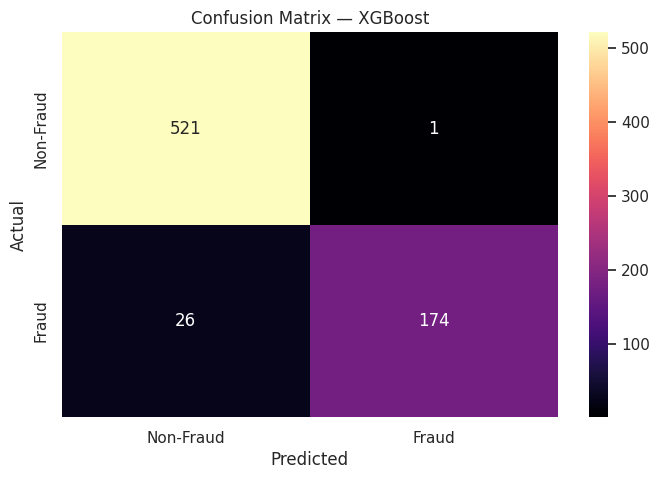

In [18]:
# CELL 9: XGBOOST MODEL (FIRST) + METRICS & PLOTS
xgb_model = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42
    ))
])

# Train
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("=============== XGBOOST RESULTS ==============")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix (Heatmap)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure()
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt="d",
    cmap="magma",
    xticklabels=["Non-Fraud", "Fraud"],
    yticklabels=["Non-Fraud", "Fraud"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — XGBoost")
plt.show()

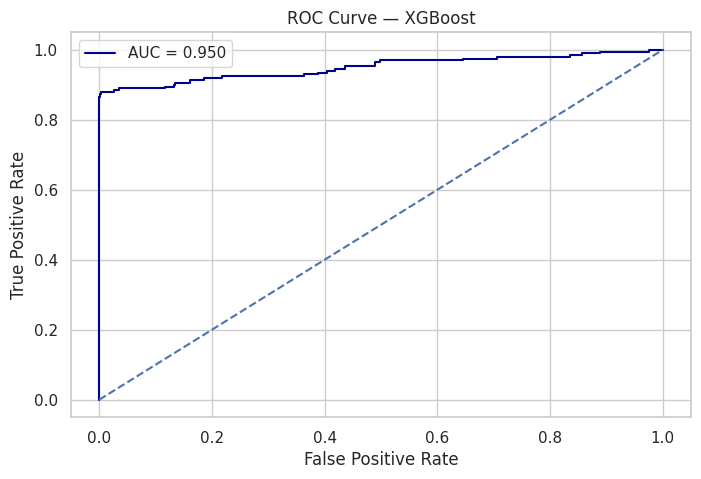

In [19]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
auc = roc_auc_score(y_test, y_prob_xgb)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", color="darkblue")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost")
plt.legend()
plt.show()

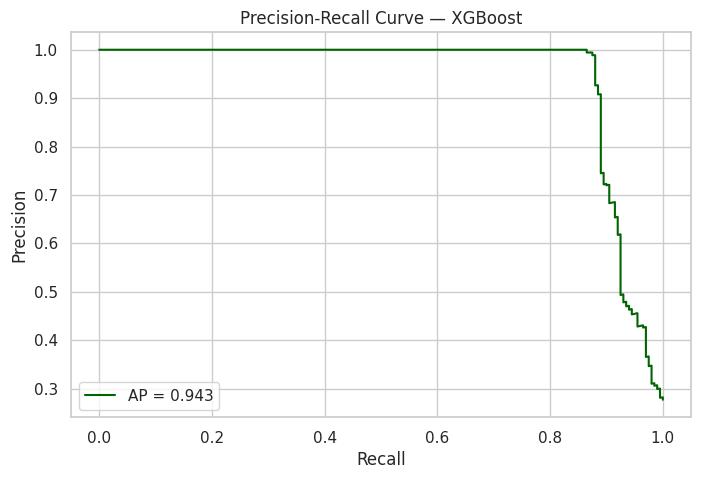

In [20]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_xgb)
ap = average_precision_score(y_test, y_prob_xgb)

plt.figure()
plt.plot(recall, precision, label=f"AP = {ap:.3f}", color="darkgreen")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — XGBoost")
plt.legend()
plt.show()

============= RANDOM FOREST RESULTS ============
Accuracy: 0.9695290858725761

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       522
           1       0.99      0.90      0.94       200

    accuracy                           0.97       722
   macro avg       0.98      0.95      0.96       722
weighted avg       0.97      0.97      0.97       722



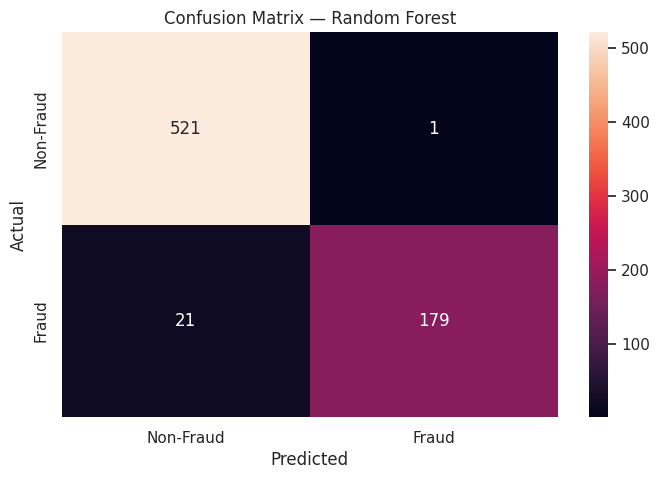

In [21]:
# CELL 10: RANDOM FOREST MODEL (SECOND) + METRICS & PLOTS
# =========================================================

rf_model = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

# Train
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("============= RANDOM FOREST RESULTS ============")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix (Heatmap)
cm_rf = confusion_matrix(y_test, y_pred_rf);
plt.figure();
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="rocket",
    xticklabels=["Non-Fraud", "Fraud"],
    yticklabels=["Non-Fraud", "Fraud"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Random Forest")
plt.show()

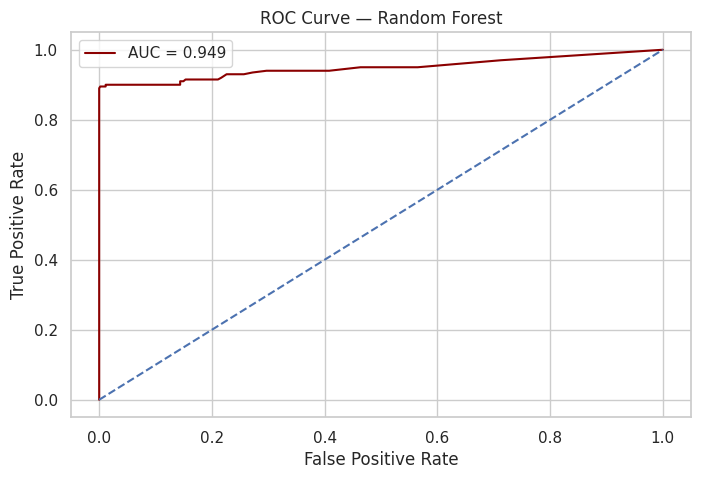

In [22]:
# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf);
auc_rf = roc_auc_score(y_test, y_prob_rf);

plt.figure();
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {auc_rf:.3f}", color="darkred")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest")
plt.legend()
plt.show()

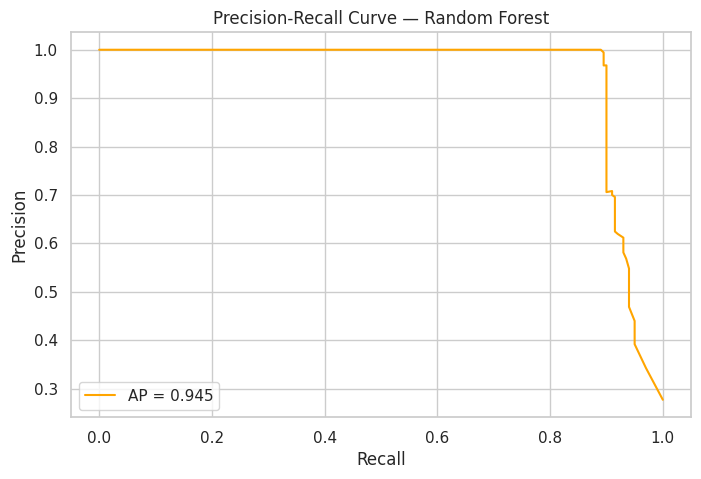

In [23]:
# Precision-Recall Curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
ap_rf = average_precision_score(y_test, y_prob_rf)
plt.figure(figsize=(8,5))
plt.plot(recall_rf, precision_rf, label=f"AP = {ap_rf:.3f}", color="orange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — Random Forest")
plt.legend()
plt.show()

In [24]:
sample = {
    "transaction_type": "P2M",
    "merchant_category": "Shopping",
    "hour_of_day": 11,
    "is_weekend": 1,
    "is_night": 0,
    "amount_log": np.log1p(30)
}

df_sample = pd.DataFrame([sample])

# Predict with XGBoost model
pred = xgb_model.predict(df_sample)[0]
prob = xgb_model.predict_proba(df_sample)[0][1]

print("Sample Prediction (XGBoost):")
print("Fraud Probability:", prob)
print("Prediction:", "FRAUD " if pred == 1 else "SAFE ")
sample_rf = {
    "transaction_type": "P2M",
    "merchant_category": "Shopping",
    "hour_of_day": 23,
    "is_weekend": 1,
    "is_night": 1,
    "amount_log": np.log1p(300000)
}

df_sample_rf = pd.DataFrame([sample_rf])

# Predict with Random Forest model
pred_rf = rf_model.predict(df_sample_rf)[0]
prob_rf = rf_model.predict_proba(df_sample_rf)[0][1]

print("Sample Prediction (Random Forest):")
print("Fraud Probability:", round(prob_rf, 4))
print("Prediction:", "FRAUD " if pred_rf == 1 else "SAFE ")

Sample Prediction (XGBoost):
Fraud Probability: 0.038498003
Prediction: SAFE 
Sample Prediction (Random Forest):
Fraud Probability: 0.9333
Prediction: FRAUD 


In [25]:
# CELL HqryHnWXuVd9: Sample Prediction for both models

# Define a single sample for prediction
sample_data = {
    "transaction_type": "P2M",
    "merchant_category": "Shopping",
    "hour_of_day": 11,
    "is_weekend": 1,
    "is_night": 0,
    "amount_log": np.log1p(30)
}

df_sample_input = pd.DataFrame([sample_data])

# Predict with XGBoost model
pred_xgb = xgb_model.predict(df_sample_input)[0]
prob_xgb = xgb_model.predict_proba(df_sample_input)[:, 1][0]

print("Sample Prediction (XGBoost):")
print("Fraud Probability:", prob_xgb)
print("Prediction:", "FRAUD " if pred_xgb == 1 else "SAFE ")

print("\n----------------------------------\n")

# Predict with Random Forest model
pred_rf = rf_model.predict(df_sample_input)[0]
prob_rf = rf_model.predict_proba(df_sample_input)[:, 1][0]

print("Sample Prediction (Random Forest):")
print("Fraud Probability:", round(prob_rf, 4))
print("Prediction:", "FRAUD " if pred_rf == 1 else "SAFE ")

Sample Prediction (XGBoost):
Fraud Probability: 0.038498003
Prediction: SAFE 

----------------------------------

Sample Prediction (Random Forest):
Fraud Probability: 0.0333
Prediction: SAFE 
